In [ ]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from textblob import Word
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nltk
from nltk import download
nltk.download('stopwords')
nltk.download('wordnet')


data = pd.read_csv('/content/text_emotion.csv')

data = data.drop('author', axis=1)

# Dropping rows with other emotion labels
data = data.drop(data[data.sentiment == 'anger'].index)
data = data.drop(data[data.sentiment == 'boredom'].index)
data = data.drop(data[data.sentiment == 'enthusiasm'].index)
data = data.drop(data[data.sentiment == 'empty'].index)
data = data.drop(data[data.sentiment == 'fun'].index)
data = data.drop(data[data.sentiment == 'relief'].index)
data = data.drop(data[data.sentiment == 'surprise'].index)
data = data.drop(data[data.sentiment == 'love'].index)
data = data.drop(data[data.sentiment == 'hate'].index)
data = data.drop(data[data.sentiment == 'neutral'].index)
data = data.drop(data[data.sentiment == 'worry'].index)

# Making all letters lowercase
data['content'] = data['content'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing Punctuation, Symbols
data['content'] = data['content'].str.replace(r'[^\w\s]',' ')

# Removing Stop Words using NLTK
stop = stopwords.words('english')
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Lemmatisation
data['content'] = data['content'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#Correcting Letter Repetitions

def de_repeat(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

data['content'] = data['content'].apply(lambda x: " ".join(de_repeat(x) for x in x.split()))

# Code to find the top 10,000 rarest words appearing in the data
freq = pd.Series(' '.join(data['content']).split()).value_counts()[-10000:]

# Removing all those rarely appearing words from the data
freq = list(freq.index)
data['content'] = data['content'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))

#Encoding output labels 'sadness' as '1' & 'happiness' as '0'
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(data.sentiment.values)

# Splitting into training and testing data in 90:10 ratio
X_train, X_val, y_train, y_val = train_test_split(data.content.values, y, stratify=y, random_state=42, test_size=0.1, shuffle=True)

# Extracting TF-IDF parameters
tfidf = TfidfVectorizer(max_features=1000, analyzer='word',ngram_range=(1,3))
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.fit_transform(X_val)

# Extracting Count Vectors Parameters
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(data['content'])
X_train_count =  count_vect.transform(X_train)
X_val_count =  count_vect.transform(X_val)

# Model 1: Multinomial Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# naive bayes tfidf accuracy 0.5289017341040463

# Model 2: Linear SVM
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred = lsvm.predict(X_val_tfidf)
print('svm using tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# svm tfidf accuracy 0.5404624277456648

# Model 3: logistic regression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_tfidf, y_train)
y_pred = logreg.predict(X_val_tfidf)
print('log reg tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# log reg tfidf accuracy 0.5443159922928709

# Model 4: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf, y_train)
y_pred = rf.predict(X_val_tfidf)
print('random forest tfidf accuracy %s' % accuracy_score(y_pred, y_val))
# random forest tfidf accuracy 0.5385356454720617

## Building models using count vectors feature
# Model 1: Multinomial Naive Bayes Classifier
nb = MultinomialNB()
nb.fit(X_train_count, y_train)
y_pred = nb.predict(X_val_count)
print('naive bayes count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# naive bayes count vectors accuracy 0.7764932562620424

# Model 2: Linear SVM
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_count, y_train)
y_pred = lsvm.predict(X_val_count)
print('lsvm using count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# lsvm using count vectors accuracy 0.7928709055876686

# Model 3: Logistic Regression
logreg = LogisticRegression(C=1)
logreg.fit(X_train_count, y_train)
y_pred = logreg.predict(X_val_count)
print('log reg count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# log reg count vectors accuracy 0.7851637764932563

# Model 4: Random Forest Classifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_count, y_train)
y_pred = rf.predict(X_val_count)
print('random forest with count vectors accuracy %s' % accuracy_score(y_pred, y_val))
# random forest with count vectors accuracy 0.7524084778420038

#Below are 8 random statements. The first 4 depict happiness. The last 4 depict sadness

tweets = pd.DataFrame(['I am very happy today! The atmosphere looks cheerful',
'Things are looking great. It was such a good day',
'Success is right around the corner. Lets celebrate this victory',
'Everything is more beautiful when you experience them with a smile!',
'Now this is my worst, okay? But I am gonna get better.',
'I am tired, boss. Tired of being on the road, lonely as a sparrow in the rain. I am tired of all the pain I feel',
'This is quite depressing. I am filled with sorrow',
])

# Doing some preprocessing on these tweets as done before
tweets[0] = tweets[0].str.replace(r'[^\w\s]',' ',regex=True)
from nltk.corpus import stopwords
stop = stopwords.words('english')
tweets[0] = tweets[0].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
from textblob import Word
tweets[0] = tweets[0].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Extracting Count Vectors feature from our tweets
tweet_count = count_vect.transform(tweets[0])

#Predicting the emotion of the tweet using our already trained linear SVM
tweet_pred = lsvm.predict(tweet_count)
print(tweet_pred)
## result
## [0 0 0 0 1 1 1 1]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


naive bayes tfidf accuracy 0.5086705202312138
svm using tfidf accuracy 0.5134874759152216
log reg tfidf accuracy 0.5105973025048169
random forest tfidf accuracy 0.49903660886319845
naive bayes count vectors accuracy 0.7649325626204239
lsvm using count vectors accuracy 0.7967244701348748
log reg count vectors accuracy 0.7976878612716763
random forest with count vectors accuracy 0.766859344894027
[0 0 0 0 1 1 1]


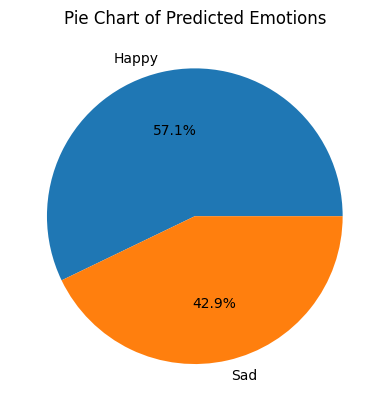

In [ ]:
import matplotlib.pyplot as plt

# Define the data
data = [4, 3]
labels = ['Happy', 'Sad']

# Create the pie chart
plt.pie(data, labels=labels, autopct="%1.1f%%")
plt.title("Pie Chart of Predicted Emotions")
plt.show()